# MNIST Classification with Vision Transformer

**Modified from original by:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date modified:** 2023/11/01<br>
**Description:** Implementing the Vision Transformer (ViT) model for MNIST digit classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
adapted for the MNIST dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

2025-07-06 01:46:36.420706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751766396.450405     282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751766396.459383     282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Prepare the data

In [2]:
num_classes = 10  # MNIST has 10 classes (digits 0-9)
input_shape = (28, 28, 1)  # MNIST images are 28x28 grayscale
# Load data

def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data('../input/mnist-numpy/mnist.npz')

# Rescale images to [0, 1] and add channel dimension
x_train = np.expand_dims(x_train, -1) / 255.0
x_test = np.expand_dims(x_test, -1) / 255.0

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1) - y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000,)


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 25  # Can increase for better performance
image_size = 28  # Keep original MNIST size (28x28)
patch_size = 7  # 7x7 patches (divides evenly into 28)
num_patches = (image_size // patch_size) ** 2  # 16 patches (28/7 = 4, 4x4=16)
projection_dim = 64  # Can reduce from original since MNIST is simpler
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4  # Reduced from 8 since MNIST is simpler
mlp_head_units = [
    256,
    128,
]  # Reduced size of the dense layers for final classifier

## Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.1, width_factor=0.1),  # Reduced zoom range
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

INFO:2025-07-06 01:46:39,816:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-07-06 01:46:39,819:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Implement multilayer perceptron (MLP)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Let's display patches for a sample image

Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 49


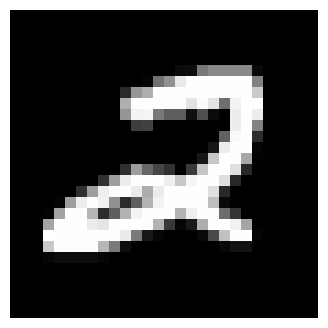

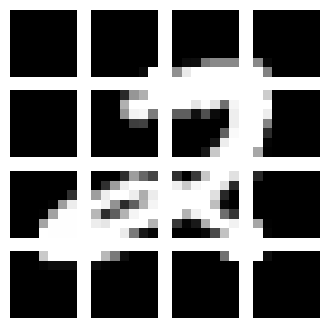

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(np.squeeze(image), cmap="gray")
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(np.squeeze(ops.convert_to_numpy(patch_img)), cmap="gray")
    plt.axis("off")

## Implement the patch encoding layer

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

## Build the ViT model

In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the model

Epoch 1/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.3900 - loss: 1.8684 - top-5-accuracy: 0.7903 - val_accuracy: 0.8930 - val_loss: 0.3590 - val_top-5-accuracy: 0.9950
Epoch 2/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.7874 - loss: 0.6584 - top-5-accuracy: 0.9814 - val_accuracy: 0.9332 - val_loss: 0.2380 - val_top-5-accuracy: 0.9963
Epoch 3/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.8535 - loss: 0.4807 - top-5-accuracy: 0.9870 - val_accuracy: 0.9503 - val_loss: 0.1767 - val_top-5-accuracy: 0.9970
Epoch 4/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.8857 - loss: 0.3932 - top-5-accuracy: 0.9899 - val_accuracy: 0.9575 - val_loss: 0.1376 - val_top-5-accuracy: 0.9977
Epoch 5/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9036 - loss: 0.3366 - top-5-accuracy: 0.9927 - val_accuracy: 0.9637 - val_loss: 0.1202 - val_top-5-accuracy: 0.9987
Epoch 6/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9158 - loss: 0.298

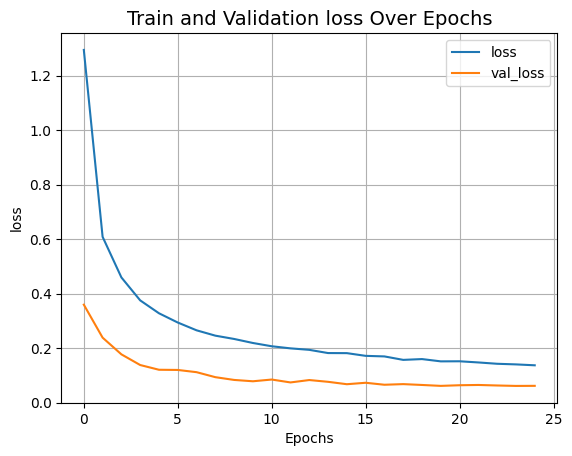

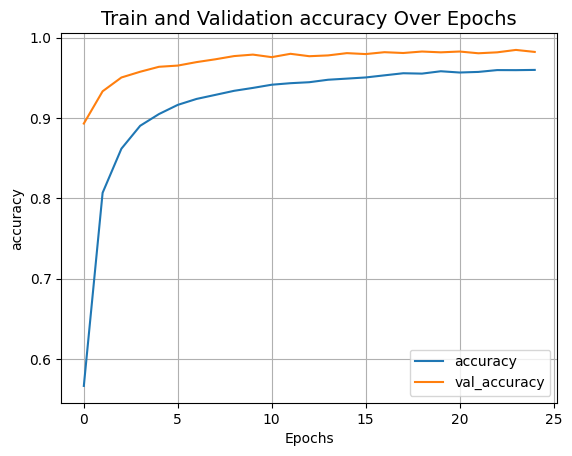

In [10]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")  # Changed from top-5-accuracy to accuracy for MNIST

After training, the ViT model should achieve good accuracy on the MNIST dataset. While Vision Transformers are typically more effective on larger images, this implementation demonstrates how they can be adapted for simpler datasets like MNIST.

To improve performance further, you could:
1. Increase the number of epochs
2. Experiment with different patch sizes
3. Adjust the projection dimensions
4. Add more transformer layers
5. Use learning rate scheduling

Note that for MNIST, traditional CNNs may still outperform ViTs due to the dataset's simplicity and small size.

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step


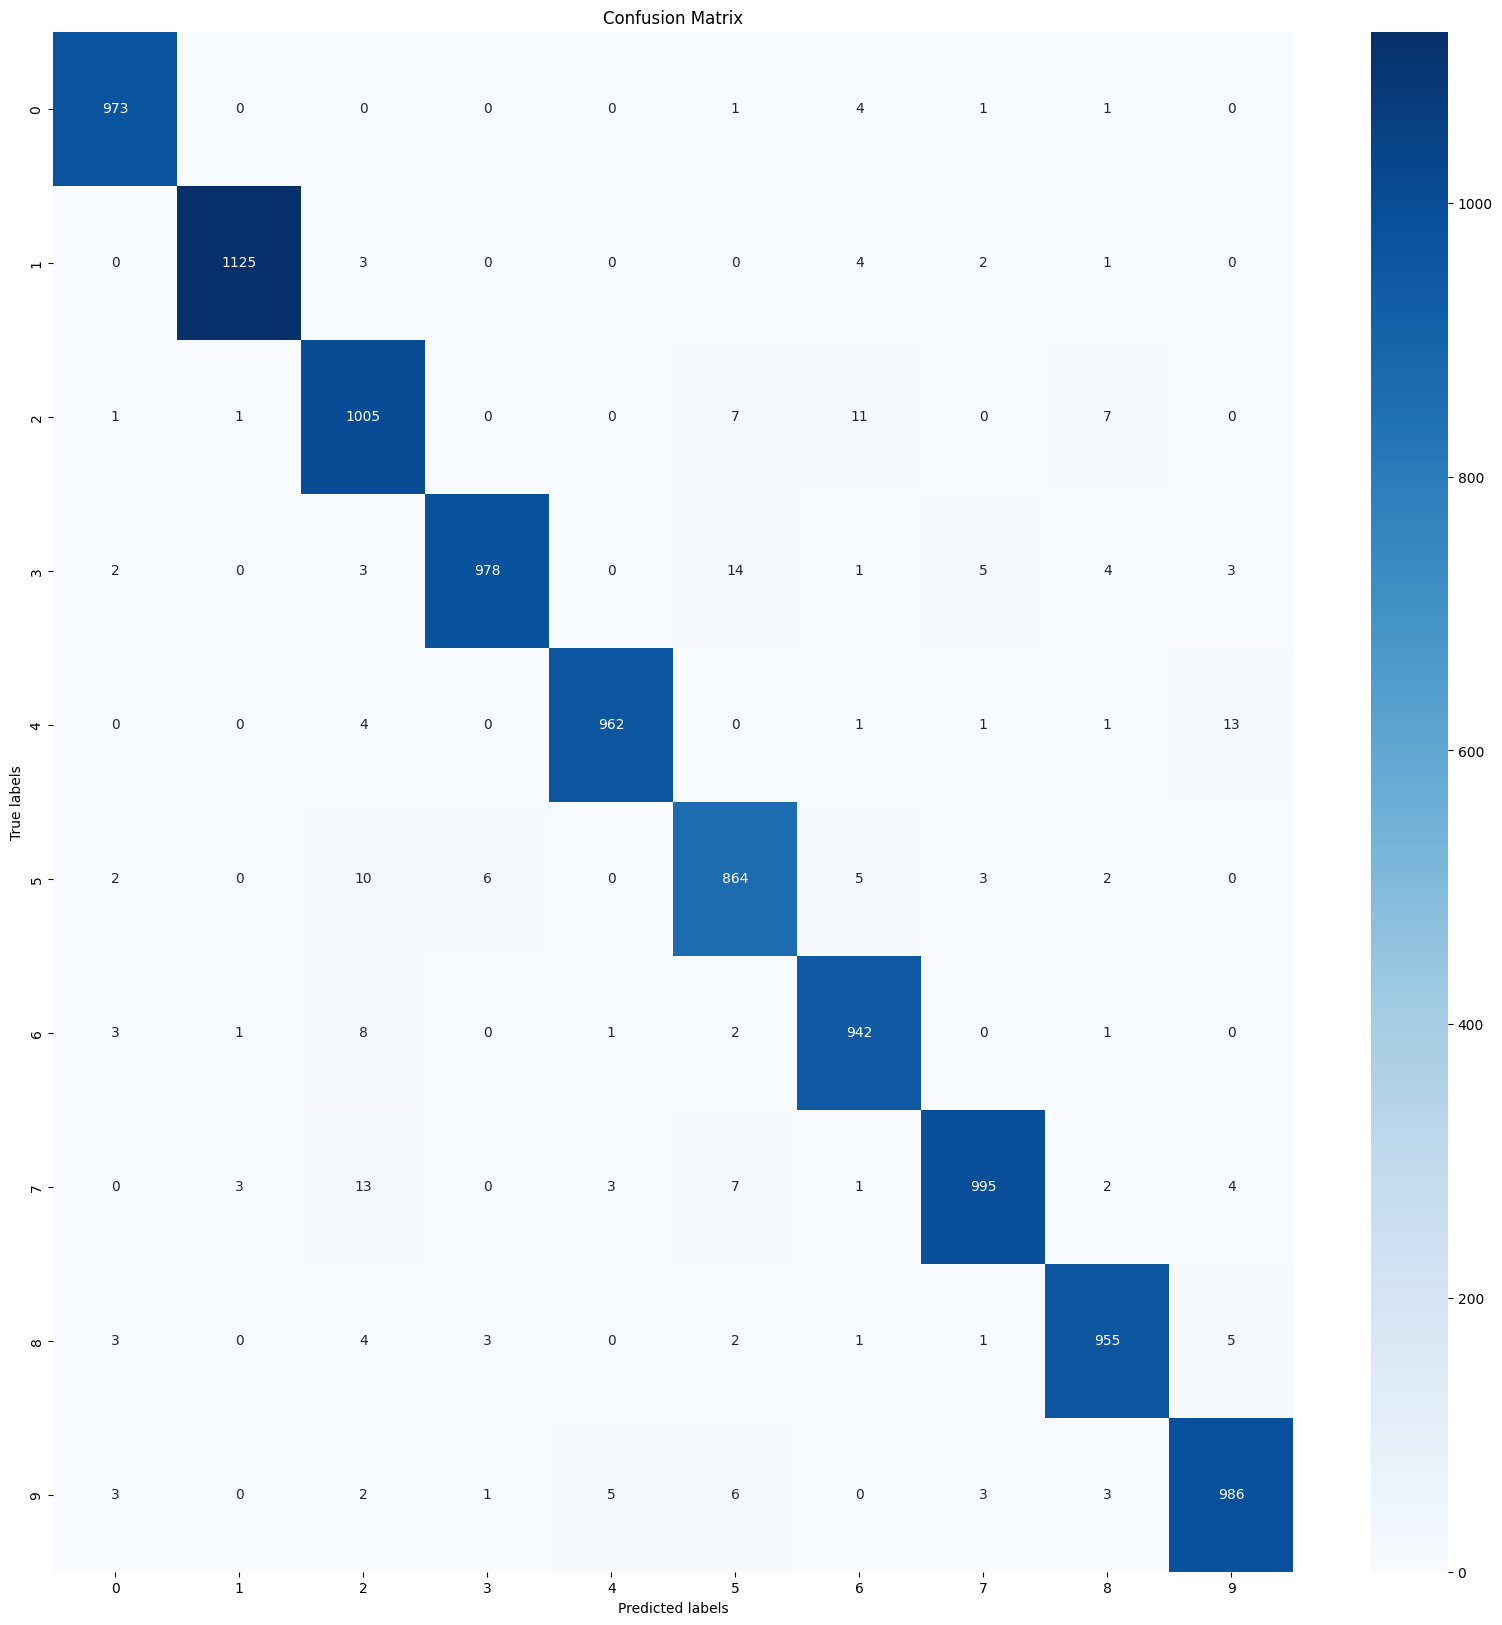

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions
model = vit_classifier
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix (for the first 20 classes to keep it readable)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.96      0.97      0.96       892
           6       0.97      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion Matrix:
[[ 973    0    0    0    0    1    4    1    1    0]
 [   0 1125    3    0    0    0    4    2    1    0]
 [   1    1 1005    0    0    7   11    0    7    0]
 [   2    0    3  978    0   14    1   